In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
%load_ext autoreload
%autoreload 2

In [2]:
from tqdm.notebook import tnrange, tqdm
from jax import random, vmap, jit, value_and_grad
from jax.experimental import optimizers, stax
import jax.numpy as np
import staxplusplus as sp
from normalizing_flows import *
from util import *
import matplotlib.pyplot as plt
from sklearn.datasets import make_swiss_roll

# In this example, we will fit a normalizing flow to a spiral distribution

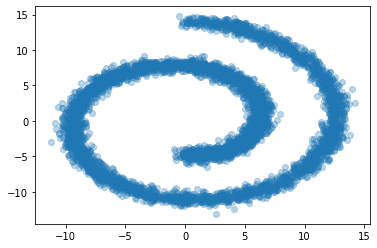

In [3]:
x, _ = make_swiss_roll( n_samples=5000, noise=0.5, random_state=0 )
x = x[:,[0,2]]
plt.scatter( x[:,0], x[:,1], alpha=0.3 )

# Build our normalizing flow

In [8]:
def Transform( out_shape, n_hidden_layers=6, layer_size=1024 ):
    out_dim = out_shape[-1]
    # Build the s and t networks that xb will be fed into
    layer_sizes = [ layer_size for _ in range( n_hidden_layers ) ]
    log_s_out = sp.sequential( sp.Dense( out_dim ), sp.Tanh() )
    t_out = sp.sequential( sp.Dense( out_dim ) )
    dense_layers = [ sp.Dense( layer_size ), sp.Relu() ]*n_hidden_layers
    coupling_param_architecture = sp.sequential( *dense_layers, sp.FanOut( 2 ), sp.parallel( log_s_out, t_out ) )

    # Split x into xa, xb and feed xb into its path
    return coupling_param_architecture

flow = sequential_flow( AffineCoupling( Transform ),
                        Reverse(),
                        AffineCoupling( Transform ),
                        Reverse(),
                        AffineCoupling( Transform ),
                        Reverse(),
                        AffineCoupling( Transform ),
                        Reverse(),
                        AffineCoupling( Transform ),                   
                        Reverse(),
                        AffineCoupling( Transform ),                   
                        Reverse(),
                        UnitGaussianPrior() )

# Initialize our model

In [9]:
key = random.PRNGKey( 0 )
init_fun, forward, inverse = flow
forward = jit( forward )

input_shape = x.shape[1:]
condition_shape = ()
cond = ()

names, output_shape, params, static_params = init_fun( key, input_shape, condition_shape )

# The loss function will be the negative mean log likelihood

In [10]:
@partial( jit, static_argnums=( 0, ) )
def nll( forward, params, static_params, x, **kwargs ):
    cond = ()
    log_px, z, updated_static_params = forward( params, static_params, np.zeros( x.shape[:-1] ), x, cond, **kwargs )
    return -np.mean( log_px ), updated_static_params

# Create the gradient function
valgrad = value_and_grad( partial( nll, forward ), has_aux=True )
valgrad = jit( valgrad )

# The last step before training is creating our optimizers

In [11]:
opt_init, opt_update, get_params = optimizers.adam( 0.0001 )
opt_update = jit( opt_update )
opt_state = opt_init( params )

# Next, we'll train the model

In [12]:
batch_size = 256

losses = []
pbar = tnrange( 5000 )
for i in pbar:
    key, *keys = random.split( key, 3 )
    
    batch_idx = random.randint( keys[0], ( batch_size, ), minval=0, maxval=x.shape[0] )
    x_batch = x[batch_idx,:]
    
    params = get_params( opt_state )
    ( val, static_params ), grad = valgrad( params, static_params, x_batch, key=keys[1], test=TRAIN )
    opt_state = opt_update( i, grad, opt_state )
    
    losses.append( val )
    pbar.set_description( 'Negative Log Likelihood: %5.3f'%( val ) )

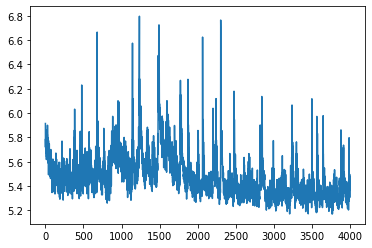

In [13]:
plt.plot( losses[1000:] )

# See how well the model fit the data

In [14]:
# Create a density plot of the data
x_grid_samples, y_grid_samples = 50, 50
x_range = np.linspace( -20, 20, x_grid_samples )
y_range = np.linspace( -20, 20, y_grid_samples )
X, Y = np.meshgrid( x_range, y_range )
grid = np.dstack( [ X, Y ] ).reshape( ( -1, 2 ) )

# Evaluate the density of the grid
log_px, _, _ = forward( params, static_params, np.zeros( grid.shape[:-1] ), grid, (), test=TEST )

# Reshape the densities
Z = np.exp( log_px ).reshape( ( x_grid_samples, y_grid_samples ) )

# Project the original data points into the latent space
_, z, _ = forward( params, static_params, np.zeros( ( 500, ) ), x[:500], (), test=TEST )

# Pull some samples from a unit Gaussian
eps = random.normal( key, ( 500, x.shape[-1] ) )
_, f_eps, _ = inverse( params, static_params, np.zeros( ( 500, ) ), eps, (), test=TEST )

(-20, 20)

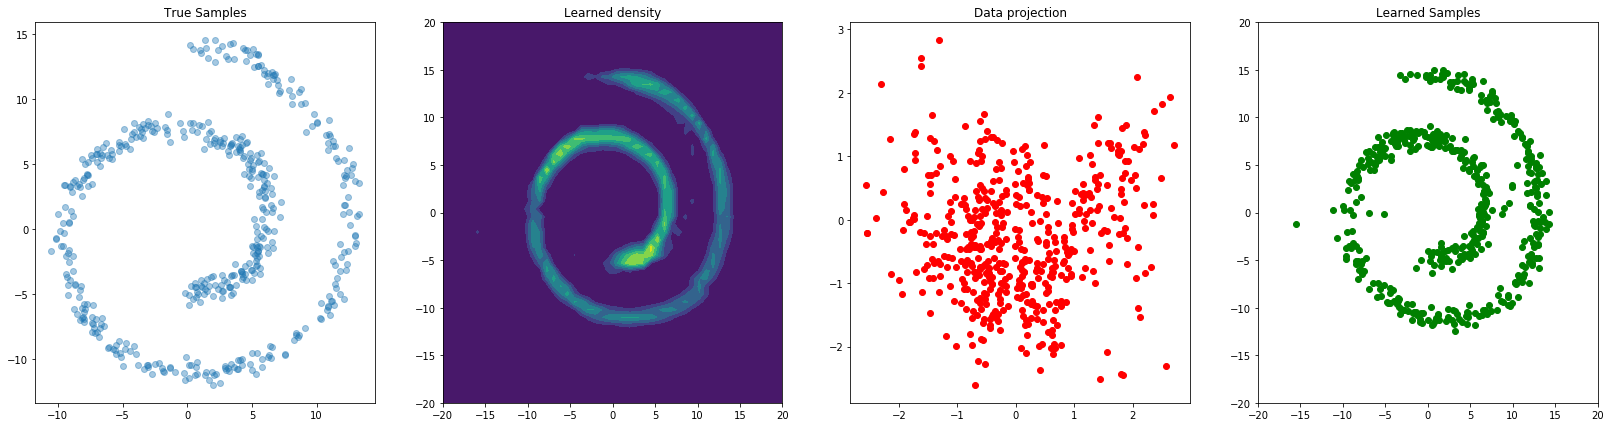

In [15]:
fig, ( ax1, ax2, ax3, ax4 ) = plt.subplots( 1, 4 )
fig.set_size_inches( 28, 7 )

ax1.scatter( x[:500,0], x[:500,1], alpha=0.4 )
ax1.set_title( 'True Samples' )

ax2.contourf( X, Y, Z, cmap='viridis' )
ax2.set_title( 'Learned density' )

ax3.scatter( z[:,0], z[:,1], color='red' )
ax3.set_title( 'Data projection' )

ax4.scatter( f_eps[:,0], f_eps[:,1], color='green' )
ax4.set_title( 'Learned Samples' )
ax4.set_xlim( -20, 20 )
ax4.set_ylim( -20, 20 )